# Forecasting Uncertainty

In this notebook, we will address the problem of **uncertainty estimation in forecasting**. 

For this purpose, the notebook has been divided in the following two main sections. The first one dedicated to give a brief overview of forecasting and the second one to address the problem of estimating the uncertainty of forecast predictions.

*Section 1: Introduction to Forecasting*:  It gives a brief introduction to the forecasting problem and the LSTM model as a baseline solution to address these type of problems. 

* The forecasting problem
* Forecast dataset: Time series
* Forecast model: LSTM
-----

*Section 2: Uncertainty estimation in Forecasting*: The LSTM model introduced before is adapated to add uncertainty estimations using a (deep) quantile learning approach<sup>1</sup>.
* Introduction to forecasting uncertainty 
* Forecasting prediction intervals: quantile deep learning
* Forecasting predictive density: mixture density networks 

 Imports

In [ ]:
import pandas as pd
import numpy as np
import time
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
tf.get_logger().setLevel('ERROR')

mpl.rcParams['figure.figsize'] = 20, 10

np.random.seed(42)
tf.random.set_seed(42)

Auxiliar functions

Here, it is defined these main auxiliar functions with the following purposes:
   * *generate_synth_tseries*. It is used for generating a time series data characteristic of forecasing problems.
   * *split_sequence*. A typical pre-preprocessing step of these type of problems. 
   * *plot_ts_forecast*. Basic visualization of time series and uncertainty forecast results.

In [ ]:
def generate_synth_tseries_1(t0: int, series_lenght: int, num_ts: int, period: int, freq: int, noise_level: float) -> pd.DataFrame:
    """
    Generate n seasonal synthetic time series starting at t0. It allows to control the series length, seasonal period,
    time frequency resolution and added noise
    """
    time_series = []
    level_ = 20
    for k in range(num_ts):
        level = level_ 
        seas_amplitude = (0.1+0.3*np.random.rand()) * level
        sig = noise_level * level # noise parameter (constant in time)
        time_ticks = np.array(range(series_lenght))
        source = level + seas_amplitude*np.sin(time_ticks*(2*np.pi)/period)
        noise = sig*np.random.randn(series_lenght)

        data = source + noise
        data = np.where(data > level_, data * noise,  data + noise*5.8)
  
        index = pd.date_range(start=t0, freq=freq, periods=series_lenght)
        time_series.append(pd.Series(data=data, index=index))
    time_series_df = pd.DataFrame(time_series)
    return time_series_df

def generate_synth_tseries_2(t0: int, series_lenght: int, num_ts: int, period: int, freq: int, noise_level: float) -> pd.DataFrame:
    """
    Generate n seasonal synthetic time series starting at t0. It allows to control the series length, seasonal period,
    time frequency resolution and added noise
    """
    time_series = []
        
    random_samples = np.random.rand() 

    for k in range(num_ts):
      if k%2==0:
        amplitude = 1
        level =10
        noise_level = 0.5
      else:
        amplitude = 5
        level=1
        noise_level = 1
      
      seas_amplitude = (amplitude+random_samples) * level
      sig = noise_level * level # noise parameter (constant in time)
      time_ticks = np.array(range(series_lenght))
      source = level + seas_amplitude*np.sin(time_ticks*(2*np.pi)/period)
      
      noise = sig*np.random.randn(series_lenght)
      data = source + noise 
      index = pd.date_range(start=t0, freq=freq, periods=series_lenght)
      time_series.append(pd.Series(data=data, index=index))
    time_series_df = pd.DataFrame(time_series)
    return time_series_df

In [ ]:
def split_sequence(sequence: np.ndarray, n_steps: int) -> (np.ndarray, np.ndarray):
    '''
    It splits a given univariate sequence into multiple samples X where each sample has a specified
    number of time steps {t0, t1, ..., tn} and the output y is a single time step t0
    Ref: https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/
    '''
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
pal = sns.diverging_palette(240, 10, n=9)
colors = pal.as_hex()

def plot_ts_forecast(ts_Y_train, ts_Y_test, q_yhat, quantiles=False):
    forecast_h = len(q_yhat[0])
    train_window = len(ts_Y_train)
    x_length = forecast_h+train_window
    aa=[x for x in range(x_length)]
    plt.figure(figsize=(20,8))
    plt.plot(aa[:train_window], ts_Y_train, marker='.', label="train")
    plt.plot(aa[train_window:], ts_Y_test, marker='.', label="test", linewidth=4)

    if quantiles:
        areas = int(len(QUANTILES)/2)
        for i in range(0,len(QUANTILES)):
            if i == int(len(QUANTILES)/2):
              plt.plot(aa[train_window:], q_yhat[i].reshape(-1), label="q_" + str(i) + "_pred", linewidth=4, color='b')
            else:
              plt.plot(aa[train_window:], q_yhat[i].reshape(-1), label="q_" + str(i) + "_pred")

            if areas > 0:
               plt.fill_between(aa[train_window:],  q_yhat[int(len(QUANTILES)/2)].reshape(-1), q_yhat[int(len(QUANTILES)/2)+areas].reshape(-1), color=colors[areas])
               plt.fill_between(aa[train_window:],  q_yhat[int(len(QUANTILES)/2)].reshape(-1), q_yhat[int(len(QUANTILES)/2)-areas].reshape(-1), color=colors[areas])
               areas = areas-1
            
    else:
        plt.plot(aa[train_window:], q_yhat[0].reshape(-1), label="forecast")
    plt.tight_layout()
    plt.subplots_adjust(left=0.07)
    plt.xlabel('time step', size=15)
    plt.legend(fontsize=15)

## Introduction to Forecasting

In forecasting, we *predict future observations* ${y_t}$  with a model ${\phi}$ fit on a historical or time series dataset $\boldsymbol{y}_{t-1} = (y_{t-1},y_{t-2},\dots,y_{t-10})'$

$$y_t = \phi(\boldsymbol{y}_{t-1}) + \varepsilon_t$$

Following this formulation, we need a time series dataset and a forecasting model:

* *Time series dataset*: We will artifically generate a simple time series dataset to ease the analysis task and control some paremeters such as the period, cycles and noise.
* *Forecasting model*: We will use the LSTM model as a baseline <sup>2</sup>

<sup>2</sup> *Why do we consider LSTM a good baseline for our problem? --  The goals of this notebook is to forecast uncertainty, so we need a model capable of modelling long term variability to keep [epistemic uncertainty](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/tree/master/bayesian_deep_learning/uncertainty_estimation#caracter%C3%ADsticas-de-la-incertidumbre-de-la-predicci%C3%B3n) low. 
LSTM seems to be a good solution as it is capable to model long-term dependences (as opposite as other traditional approaches)*


* Resources:
    - [Quantitative forecasting online-course](https://quantecon.org/)
    - [Forecasting methods (traditional approches)](https://otexts.com/fpp2/data-methods.html)

####  Time series dataset

In this section, we will generate a synthetic dataset with the auxiliar function defined before *generate_synth_tseries* and the following parameters:

*Controllable parameters setup*

In [ ]:
# ----- time series basic definition
t0 = '2016-01-01 00:00:00' # initial time step
num_ts = 1 # number of time series to be generated
total_days = 20 # series total length in days

# ----- time series patterns
freq = 'H' # See here for a list of frequency aliases:  https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
period = 100
noise_level = 0.05 # the level of noise to be added to the whole series

# ----- split train, test parameters
tseries_length = total_days * 24 # time series length in the selected frequency
train_days = 15 * 24 # dataset train length in the selected frequency --> 15 days * 24 hours

In [ ]:
time_series_df = generate_synth_tseries(t0, tseries_length, num_ts, period, freq, noise_level)

As we can see in this plot, this particular configuration generate a synthetic seasonal time series dataset of 20 days starting at t0='2016-01-01 00:00:00' and hourly resolution. Cycles have a period pattern of 14 hours. 

Additionally, it is randomly added some white noise with a constant level in time and variable amplitude of 10 units as maximum

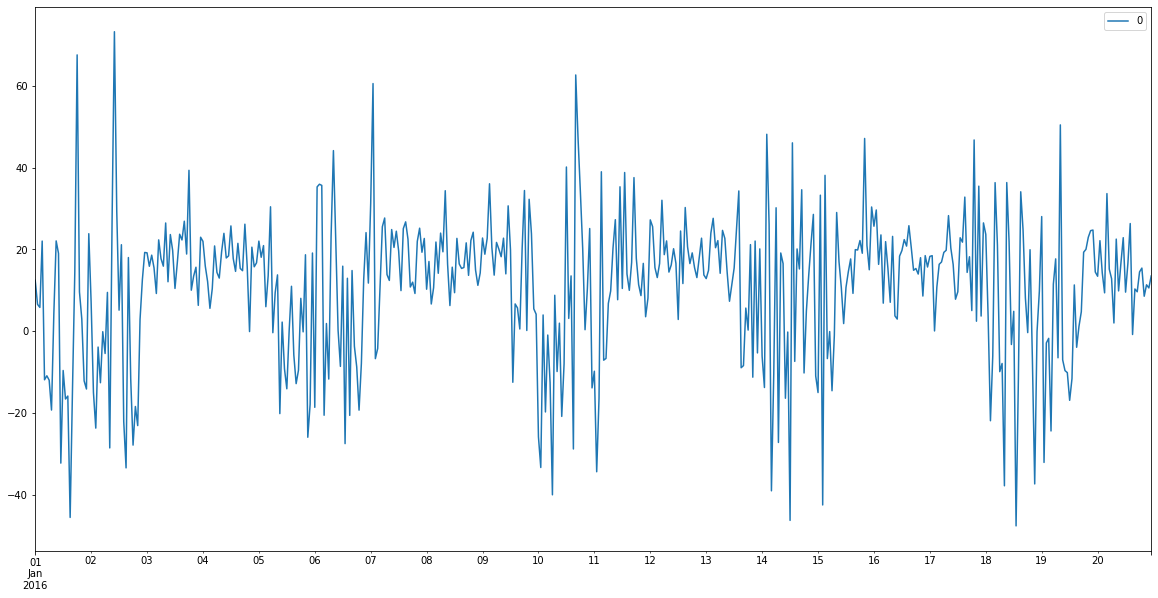

In [ ]:
time_series_df.T.plot()

**Split time series in train and test**

We split the time series dataset in **train and test**:

* **Train**: 15 days (converted to hours)
* **Test**: 5 days (converted to hours)

In [ ]:
train_ts = time_series_df.iloc[:, 0:train_days]
test_ts = time_series_df.iloc[:,train_days-1:]

We obtain two Pandas' dataframes one for training and another for testing

In [ ]:
train_ts.shape, test_ts.shape

((1, 360), (1, 121))

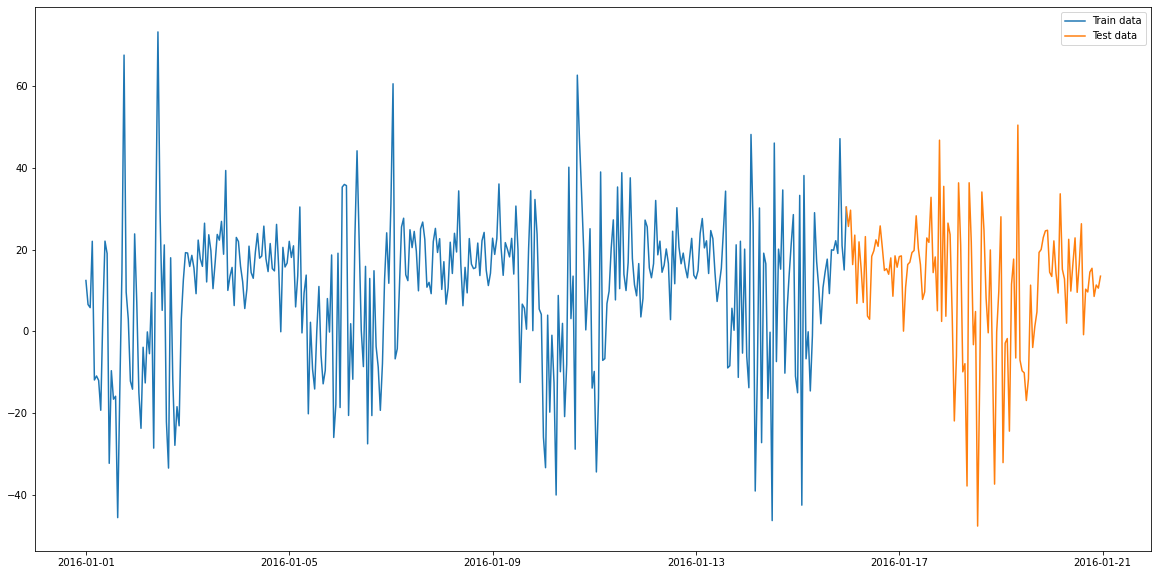

In [ ]:
plt.plot(train_ts.T, label='Train data')
plt.plot(test_ts.T, label='Test data')
plt.legend()

As we can see in this plot, the split is done sequentially and not randomly generated across the whole series. This sequential splitting will allow us to keep the time dependant patterns chacteristic of forecasting problems <sup>3</sup>

<sup>3</sup> *In real problems, it is common to used more complex testing strategies that will depend on the business objectives and available data to test. For example, one common strategy is to use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) with specific seasons or months from different years to further understand its behavior accross specific seasons or months. However, these type of strategies are out of the scope of this notebook*

#### Forecasting function: LSTM

* Resource [Theoretical concepts behind LSTM explained simply](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

Once that we have generated our synthetic time series dataset. Here, we will implement the forecasting model ${\phi}$ as a Univariate LSTM.

The [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) in contrast to traditional RNN <sup>4</sup> uses memory cells to store, access and modify the internal state, allowing it to **better discover long-range temporal relationships** solving what is known as the [vanishing gradient problem](#https://medium.com/datadriveninvestor/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577) present in RNN. This advantage is particularly useful if we consider large temporal datasets.<sup>5</sup>

<sup>4</sup>*LSTM is considered a type of [RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network)*

<sup>5</sup>*This advantage is specially important in estimating uncertainty because we are interested in a model capable of modelling the long term variability to keep epistemic uncertainty low*

*LSTM input parameters*

In [ ]:
# ------LSTM input parameters
features = num_ts # We are working with univariate series so the number of features is 1
timesteps = 2 # we will work with a batch of 2 time steps

In this example, we build a RNN model  composed of a single layer with the following:

```LSTM(50, activation='relu', input_shape=(timesteps, features)```

* *50 units*. These are the hidden states. This means that at each point in time, the time series will become 50 different variables as output space.
* *input_shape*. A dataset with one time series (one feature) and samples of 2 timesteps. 

```model.add(Dense(1))```
* *Output*. One output prediction. It will forecast just the next hour value

Keras default is not stateful. Thus, we may loose information between batches (keras default batch_size is 32), this is not a problem since the generated time series has a very clear periodic patterns each 14 values. These type of test are out of the scope of this notebook. However, for more complex datasets, it might be useful to declare the [LSTM to stateful](https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/)<sup>6</sup>.

<sup>6</sup>*RNN layers may be 'stateful', which means that the states computed for the samples in one batch will be reused as initial states for the samples in the next batch*

In [ ]:
def lstm_model(X, ts_Y_train, n_steps, n_features):
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(timesteps, features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, ts_Y_train, epochs=200, verbose=0)
    return model

**Pre-processing step**

The split_sequence() function will split the univariate sequence into multiple samples where each sample has a specified number of time steps. As consequence, this function will also transform specific dates to time steps

In [ ]:
ts_X_test, ts_Y_test = split_sequence(test_ts.values[0], timesteps)
ts_X_train, ts_Y_train = split_sequence(train_ts.values[0], timesteps)

# reshape X as input for the lstm [samples, timesteps, features]
X_train = ts_X_train.reshape((ts_X_train.shape[0], ts_X_train.shape[1], features)) 
X_test = ts_X_test.reshape((ts_X_test.shape[0], ts_X_test.shape[1], features))

In [ ]:
# reshape X as input for the lstm [samples, timesteps, features]
X_train = ts_X_train.reshape((ts_X_train.shape[0], ts_X_train.shape[1], features)) 
X_test = ts_X_test.reshape((ts_X_test.shape[0], ts_X_test.shape[1], features)) 

We have split the dataset into 118 samples with 2 values (timesteps) each sample 

In [ ]:
X_test.shape, ts_Y_test.shape #  [samples, timesteps, features]

((119, 2, 1), (119,))

* We have a forecasting horizon of 1 (t+1) as we can see in the Y test set
* We need a sample input of two hours to forecast the next hour  

In [ ]:
X_test[0:5], ts_Y_test[0:5]

(array([[[30.37199027],
         [25.66633308]],
 
        [[25.66633308],
         [29.64210385]],
 
        [[29.64210385],
         [16.3382265 ]],
 
        [[16.3382265 ],
         [23.54279683]],
 
        [[23.54279683],
         [ 6.84806846]]]),
 array([29.64210385, 16.3382265 , 23.54279683,  6.84806846, 21.89515368]))

**Generate forecasting results**

We train the lstm model using the training generated dataset. This train dataset has two dimensions. One is the sample input (two time steps) as X_train and the other is the Y_train true value of each sample  

In [ ]:
X_train[0:2], ts_Y_train[0:2]

(array([[[12.4392152 ],
         [ 6.56478919]],
 
        [[ 6.56478919],
         [ 5.80722926]]]), array([ 5.80722926, 22.03566901]))

The first time step starts at value 8.58835483

In [ ]:
lstm_fitted = lstm_model(X_train, ts_Y_train, timesteps, features)

Finally, we will generate the forecast of Y based for the whole time interval passed using X_test 

In [ ]:
yhat = lstm_fitted.predict(X_test, verbose=0)

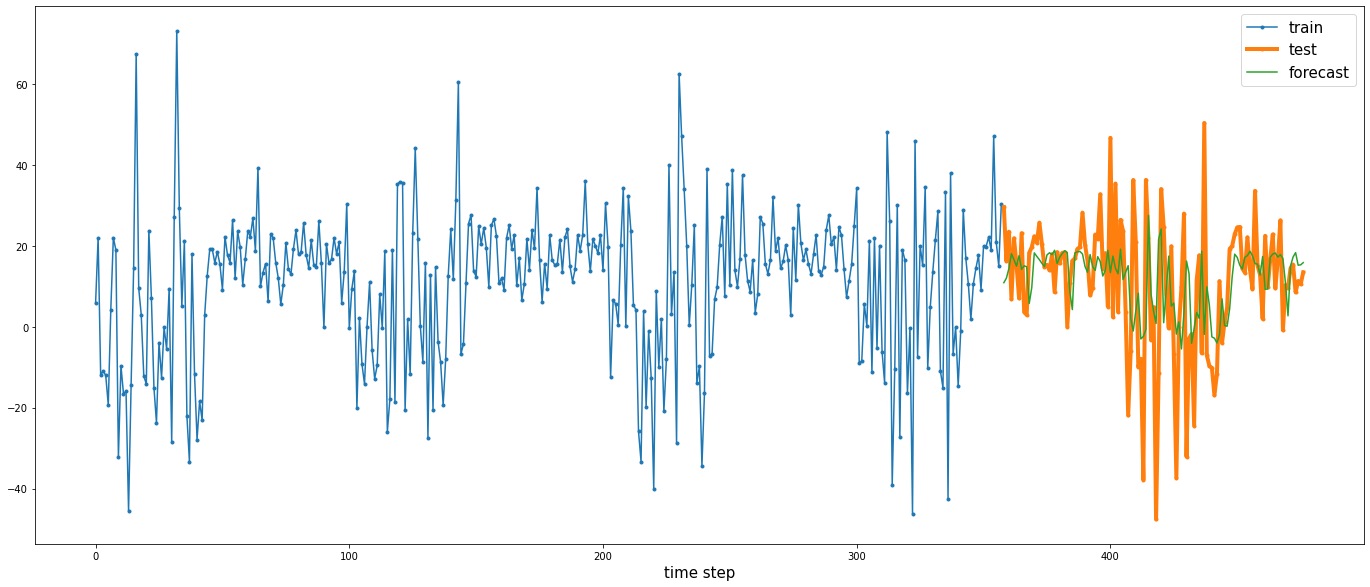

In [ ]:
plot_ts_forecast(ts_Y_train, ts_Y_test, yhat.reshape(yhat.shape[1], yhat.shape[0]))

As we can see in the plot, we have generated a forecast for the whole test set time interval. However, if we can only generate one forecast using one sample with two X values or time steps 

In [ ]:
X_one_sample = X_test[0:1]
X_one_sample.shape

(1, 2, 1)

In [ ]:
yhat_one_step = lstm_fitted.predict(X_one_sample, verbose=0)

In [ ]:
yhat_one_step

array([[10.936254]], dtype=float32)

As we can see, we have one prediction each two time steps <sup>7</sup>.

<sup>7</sup> This forecasting strategy is the most simpliest one, however other [strategies may be applied](https://raw.githubusercontent.com/beeva/TEC_LAB-bayesian_probabilistic/master/bayesian_deep_learning/uncertainty_estimation/quantile_regression/lstm/img/output_input_configuration.webp) depending on the specific use case. For this purpose, it might be necessary to adapt the pre-processing step defined before to produce the desire configuration. These configuration tests are out of the scope of this notebook

## Uncertainty estimation in Forecasting

In this section, we will address the problem of reporting the uncertainty of each of the forecast predictions obtained above.

For this purpose, we will use the same **LSTM model** but using *the pinball loss* function to follow a **quantile deep learning** approach. The usage of this loss function will give us the quantiles or prediction intervals as uncertainty metric similarly as it is done in [previous work](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/bayesian_deep_learning/uncertainty_estimation/quantile_regression/experiments/01-quantile_regression/01-quantile_regression_techniques.ipynb).

### Uncertainty Forecasting with Quantile Deep Learning

<sup>1</sup> *The deep quantile learning technique has been successfully applied in regression with a simple ANN model -  [see previous work](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/bayesian_deep_learning/uncertainty_estimation/quantile_regression/experiments/01-quantile_regression/01-quantile_regression_techniques.ipynb). As this technique is agnostic of the underlying deep learning model, here it is proposed an LSTM model instead in order to solve the forecasting problem.*

##### LSTM +  Quantile Deep Learning

Here, we implement the naive method of quantile deep learning as it is done in [deep quantile regression](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/bayesian_deep_learning/uncertainty_estimation/quantile_regression/experiments/01-quantile_regression/01-quantile_regression_techniques.ipynb).

This method is also called in the literature [Independent Deep Quantile Estimation](https://arxiv.org/pdf/1808.08798.pdf) and it fits N independant deep quantile models (one for each quantile) where N is the number of quantiles specified.

Here, we will specify 5 quantiles, so we will fit 5 fixed indepent quantile deep learning models.

In [ ]:
# -----  quantiles to be predicted
QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9] # N quantiles

It is important to notice that we are not predicting the conditional mean of Y, E[Y|X] with MSE as a loss as it is done with the LSTM model defined before. Here, we are using the pinball/titled loss to be able to approximate the response variable Y to a specific quantil of the P(Y|X).

Basically, the introduced change in the network architecture is solely the following:

* ${\phi(x)}$ = y with MSE →  ${\phi(x)}$  = y with Pinball Loss

In [ ]:
def tilted_loss(q, y, f):
    #e = (y - f) sometimes the error is computed in this form. Quantiles are inverted 
    e = (f - y)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), axis=-1)

In [ ]:
def lstm_dqr_model(X, ts_Y_train, n_steps, n_features, q):
    # define model
    model = tf.keras.Sequential()
    model.add(layers.LSTM(50, activation='relu', input_shape=(timesteps, features)))
    model.add(layers.Dense(1))
    model.compile(optimizer='adagrad', loss=lambda y, f: tilted_loss(q, y, f))
    # fit model
    model.fit(X, ts_Y_train, epochs=400, verbose=0)
    return model

As it has been explained before, here we will generate N independant deep quantile models (one for each quantile of QUANTILES list).

In [ ]:
q_models = []

for i in range(0,len(QUANTILES)):
    q_models.append(lstm_dqr_model(X_train, ts_Y_train, timesteps, features, QUANTILES[i]))

#### Uncertainty results

Here, we will generate N independant forecast predictions per each defined quantile.

In [ ]:
q_yhat = []

# predict each quantile of QUANTILES list
for i in range(0,len(QUANTILES)):
    q_yhat.append(q_models[i].predict(X_test, verbose=0))

We visualize uncertainty results using the declared auxiliar function plot_ts_forecast

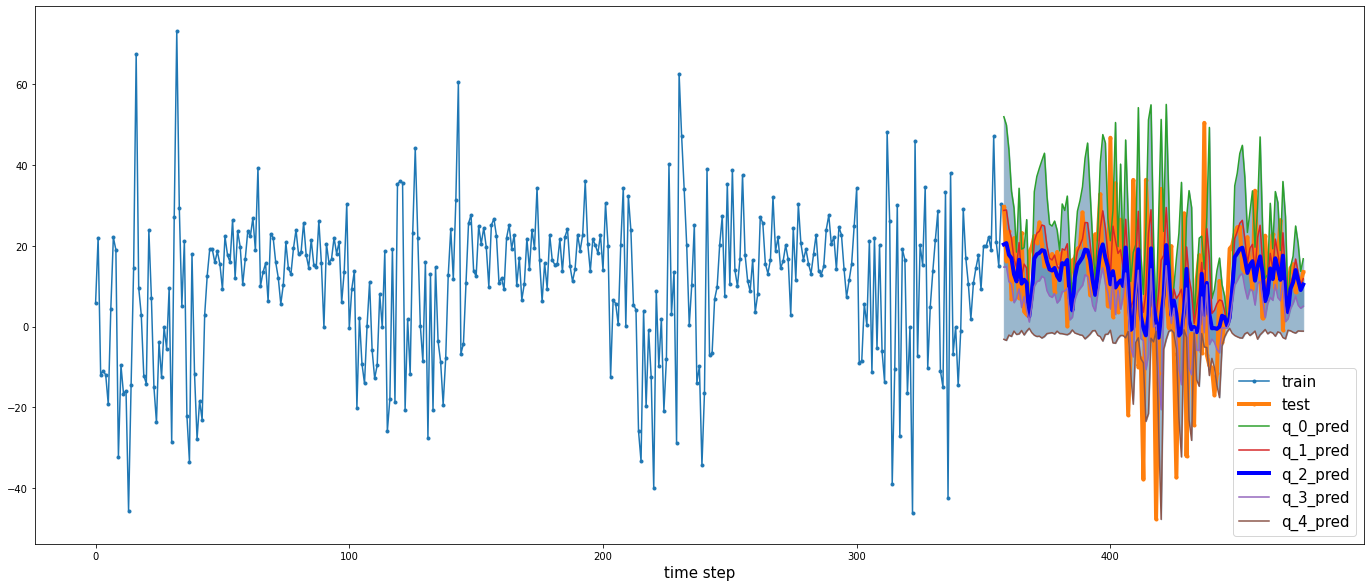

In [ ]:
plot_ts_forecast(ts_Y_train, ts_Y_test, q_yhat, quantiles=True)
plt.show()

We zoom it results to be able to better visualize the quantile estimations.

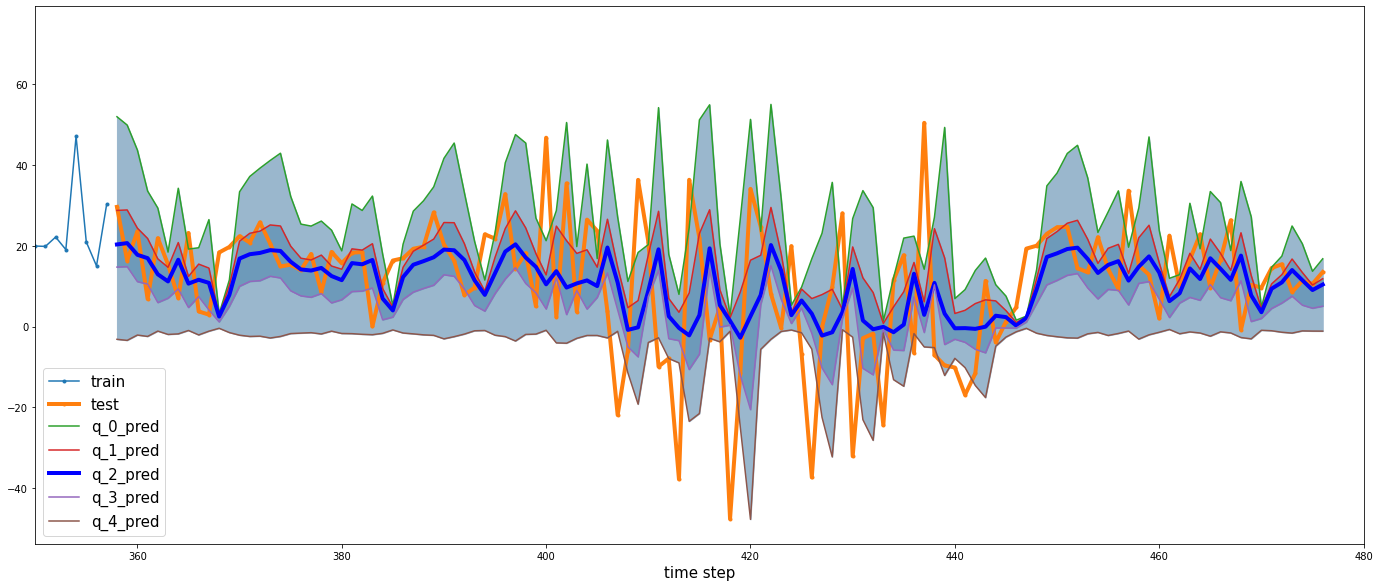

In [ ]:
plot_ts_forecast(ts_Y_train, ts_Y_test, q_yhat, quantiles=True)
plt.xlim(350,480)
plt.show()

As we can see in this plot, we obtain 5 quantile forecasting estimations (as forecasting values of Y) per time step. Thus, if we take the predicted quantiles of 0.1 and 0.9 we are covering the 80% of observations.

Using these quantiles, we are estimating uncertainty (the range of values that we our prediction may take) with a 80% confidence as maximum. The wider is this interval, the more uncertain the prediction will be.

Other interesting insight that we can extract from this plot, it is that we still have the quantile crossing problem,  particuarly in the ones in the middle.

#### Conclusions

Goals achieved in this notebook:

* A basic understanding of forecasting.
* Validation of deep quantile learning as a technique for estimating uncertainty in forecasting problems

    *Disadvantages of the proposed uncertainty estimation technique*:
     * The proposed technique implies to **adjust N indepent models**. This might be computationally expensive with more complex dataset and multi-level time series data.
     * **Crossing quantile problem**: This might causes a performance degradation and interpretability problems.

##### References




- [1] https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- [2] https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
- [3] https://towardsdatascience.com/deep-quantile-regression-c85481548b5a
- Application in finance to estimate the business metric [VaR](http://alfredgalichon.com/wp-content/uploads/2012/10/Galichon_slides.pdf)

***References***

[1] Rodrigues, F., & Pereira, F. C. (2020). Beyond Expectation: Deep Joint Mean and Quantile Regression for Spatiotemporal Problems. IEEE Transactions on Neural Networks and Learning Systems, 1–13. https://doi.org/10.1109/tnnls.2020.2966745

[2] Brando, A., Rodríguez-Serrano, J. A., Vitrià, J., & Rubio, A. (2019). Modelling heterogeneous distributions with an Uncountable Mixture of Asymmetric Laplacians. (NeurIPS 2019). Retrieved from http://arxiv.org/abs/1910.12288



### Uncertainty Forecasting with Mixture Density Networks

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

keras.backend.clear_session()

import matplotlib.gridspec as grid_spec

The [mixture density networks (Bishop, 1994)](https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf) are a class of models obtained by combining a conventional neural network with a [mixture density model](https://en.wikipedia.org/wiki/Mixture_model). This method allow us to estimate a conditional [mixture distribution](https://en.wikipedia.org/wiki/Mixture_distribution) of the target.

The probability density of the target data is then represented as a linear combination of the kernel functions $\phi_i$  with the following formula:

$$p(\boldsymbol{y} | \boldsymbol{x} ) = \sum_{i=1}^m \alpha_i (\boldsymbol{x}) \phi_i (\boldsymbol{y} |  x_m , \lambda_i ... )$$

*Formula parameters* 

* $m$ corresponds to the index of the corresponding mixture. There are up to $m$ mixture components (distributions) per output, being a selectable parameter.
* $\alpha$ is the mixing coefficient. To understand this coefficient, we can imagine the sliders that control the mix of $m$ different audio outputs. This parameter is conditioned by the input x.
* $\phi_i$ this is the corresponding input distribution to be mixed. The distribution selection is an explicit prior of the model and it can be chosen according to the type of application. 
* $\lambda$ are the parameters of the $\phi_i$ distribution. In the case we denote $\phi_i$ as a Gaussian distribution, these parameters would correspond to λ1 would be the mean conditional mean μ (x) and λ2 the standard deviation σ (x). The distributions can have different number of parameters (eg: Bernoulli and Chi2 have 1 parameter, Beta has 2, and the truncated Gaussian has up to 4 parameters). These are parameters that also form the output of the network.

*Parameter estimation*

The problem that arises when estimating the distribution of $p(\boldsymbol{y} | \boldsymbol{x} )$ is that, on the one hand, we do not even know the different processes that generate these sub-populations nor to which sub-population a specific observation belongs. For this reason we compute the log-likelihood and apply the [MLE (Maximum Likelihood Estimation) algorithm](https://towardsdatascience.com/gaussian-mixture-models-and-expectation-maximization-a-full-explanation-50fa94111ddd).

Following this approximation with defined the loss function to minimize the log-likelihood as follows:

$$ \log \mathcal{L}(\boldsymbol{y} \mid \boldsymbol{x}) = - \log \left( p(\boldsymbol{y} \mid \boldsymbol{x}) \right) = - \log \left(\overset{m}{\underset{i=0}{\sum}} \alpha_i (\boldsymbol{x}) \phi_i (\boldsymbol{y} | \boldsymbol{x} ) \right) $$

Generate time series

In [ ]:
# ----- time series basic definition
t0 = '2016-01-01 00:00:00' # initial time step
num_ts = 10 # number of time series to be generated
total_days = 20 # series total length in days

# ----- time series patterns
freq = 'H' # See here for a list of frequency aliases:  https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
period = 100
noise_level = 0.15 # the level of noise to be added to the whole series

# ----- split train, test parameters
tseries_length = total_days * 24 # time series length in the selected frequency
train_days = 15 * 24 # dataset train length in the selected frequency --> 15 days * 24 hours

In [ ]:
time_series_df = generate_synth_tseries_2(t0, tseries_length, num_ts, period, freq, noise_level)
time_series_df

,2016-01-01 00:00:00,2016-01-01 01:00:00,2016-01-01 02:00:00,2016-01-01 03:00:00,2016-01-01 04:00:00,2016-01-01 05:00:00,2016-01-01 06:00:00,2016-01-01 07:00:00,2016-01-01 08:00:00,2016-01-01 09:00:00,2016-01-01 10:00:00,2016-01-01 11:00:00,2016-01-01 12:00:00,2016-01-01 13:00:00,2016-01-01 14:00:00,2016-01-01 15:00:00,2016-01-01 16:00:00,2016-01-01 17:00:00,2016-01-01 18:00:00,2016-01-01 19:00:00,2016-01-01 20:00:00,2016-01-01 21:00:00,2016-01-01 22:00:00,2016-01-01 23:00:00,2016-01-02 00:00:00,2016-01-02 01:00:00,2016-01-02 02:00:00,2016-01-02 03:00:00,2016-01-02 04:00:00,2016-01-02 05:00:00,2016-01-02 06:00:00,2016-01-02 07:00:00,2016-01-02 08:00:00,2016-01-02 09:00:00,2016-01-02 10:00:00,2016-01-02 11:00:00,2016-01-02 12:00:00,2016-01-02 13:00:00,2016-01-02 14:00:00,2016-01-02 15:00:00,...,2016-01-19 08:00:00,2016-01-19 09:00:00,2016-01-19 10:00:00,2016-01-19 11:00:00,2016-01-19 12:00:00,2016-01-19 13:00:00,2016-01-19 14:00:00,2016-01-19 15:00:00,2016-01-19 16:00:00,2016-01-19 17:00:00,2016-01-19 18:00:00,2016-01-19 19:00:00,2016-01-19 20:00:00,2016-01-19 21:00:00,2016-01-19 22:00:00,2016-01-19 23:00:00,2016-01-20 00:00:00,2016-01-20 01:00:00,2016-01-20 02:00:00,2016-01-20 03:00:00,2016-01-20 04:00:00,2016-01-20 05:00:00,2016-01-20 06:00:00,2016-01-20 07:00:00,2016-01-20 08:00:00,2016-01-20 09:00:00,2016-01-20 10:00:00,2016-01-20 11:00:00,2016-01-20 12:00:00,2016-01-20 13:00:00,2016-01-20 14:00:00,2016-01-20 15:00:00,2016-01-20 16:00:00,2016-01-20 17:00:00,2016-01-20 18:00:00,2016-01-20 19:00:00,2016-01-20 20:00:00,2016-01-20 21:00:00,2016-01-20 22:00:00,2016-01-20 23:00:00
0,10.860295,8.267880,12.478673,7.767532,10.838004,14.541793,12.373560,15.677746,18.461574,22.334259,26.070237,19.961342,29.863635,28.736968,27.364758,26.354326,27.861966,32.817703,33.549804,34.587301,28.529171,31.435032,35.641944,25.994961,27.635355,29.345639,33.725433,33.689402,27.769891,21.117148,29.553457,23.320987,19.982224,20.563089,27.898267,32.391268,25.038761,25.100816,29.102586,14.557989,...,21.734965,18.664978,23.051633,17.411234,26.432252,15.933791,18.293609,9.836964,14.930048,12.585155,9.717469,6.281523,4.395247,7.801777,8.353572,3.410833,4.344252,1.607595,1.211426,-1.325172,-1.234088,11.209939,-1.629940,-0.817428,-2.654170,-6.900165,0.203584,-8.338266,-2.156632,-9.583602,-13.122400,-6.833215,-14.447553,-6.435340,-15.198233,-10.860496,-16.386088,5.007294,-17.194009,-8.611127
1,2.143304,2.408517,2.594135,1.793296,3.824961,3.744794,3.394007,3.763981,3.551212,3.265950,5.720687,6.089930,4.172890,5.166481,5.423059,5.762020,6.068243,7.140333,5.615281,5.664016,7.873099,6.277707,5.558535,6.394683,6.584798,8.481508,7.839677,8.027334,7.641544,7.686596,5.948398,6.311761,5.372583,5.982983,6.688053,5.929259,6.877963,4.178850,5.557238,3.529420,...,4.904509,4.159652,3.700073,4.711875,2.527365,3.417918,1.704912,2.223209,0.547218,0.709614,0.917857,2.442518,0.358011,1.544144,-0.253549,-1.218488,0.357650,-1.086383,-2.497857,-1.705030,-2.776131,-4.766757,-2.121026,-2.225332,-1.728540,-3.372532,-4.252671,-3.358482,-3.512678,-2.872082,-4.681107,-4.905931,-5.537115,-4.342351,-6.463113,-4.150458,-4.327016,-4.294743,-4.683345,-3.207374
2,14.359967,8.174302,9.468707,9.211617,17.547541,10.952659,22.509048,24.817698,14.886123,19.395205,21.407055,26.700179,31.234829,15.616451,23.253385,24.255997,19.263013,24.456897,29.570750,26.519173,20.599431,43.030609,30.255101,29.672012,23.737808,30.568986,28.406371,19.670924,23.572934,32.634826,38.042625,29.748394,32.947322,26.103671,25.833631,31.040976,33.158175,30.549396,17.856296,21.945469,...,28.150594,19.306456,25.219163,17.454427,12.253805,14.437049,9.950875,10.782223,13.419230,13.767713,2.049043,8.703472,4.652319,3.147940,5.872299,1.294388,9.818603,7.737477,6.627938,-2.797498,-6.136445,-1.870114,-3.939854,-7.088028,-10.722961,-5.793671,-8.286709,-3.440712,-4.106375,-2.408568,-14.619015,-6.654904,-12.561540,-15.215613,-11.370451,-3.921931,-11.089031,-1.286268,-6.179819,-10.630648
3,2.160048,1.817528,0.810234,3.969327,2.733351

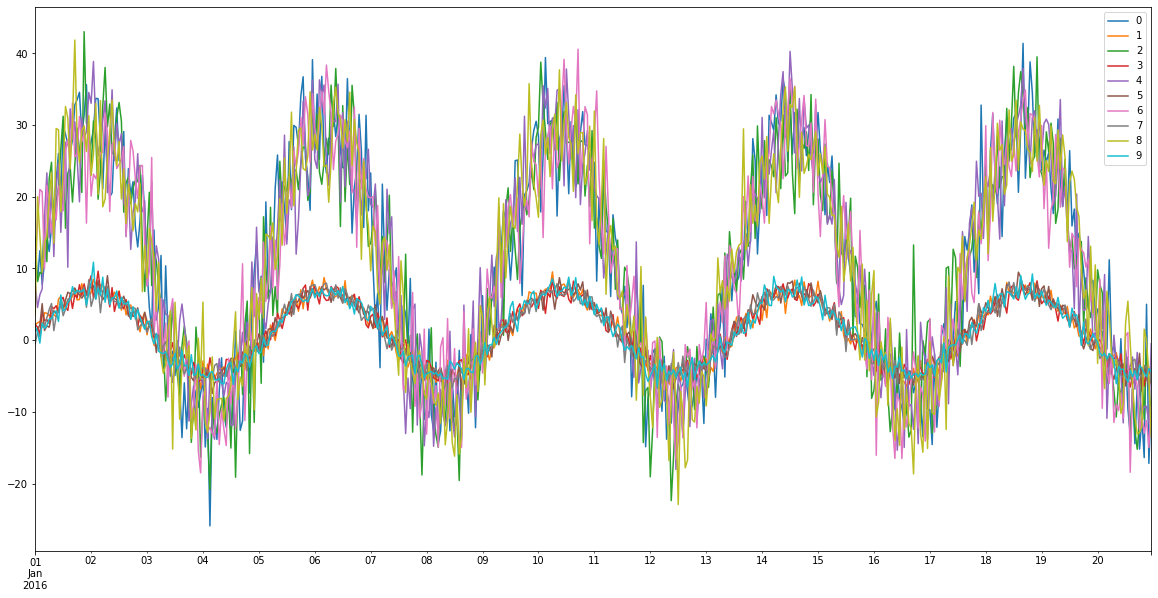

In [ ]:
time_series_df.T.plot()

**Split time series in train and test**

We split the time series dataset in **train and test**:

* **Train**: 15 days (converted to hours)
* **Test**: 5 days (converted to hours)

In [ ]:
train_ts = time_series_df.iloc[:, 0:train_days]
test_ts = time_series_df.iloc[:,train_days-1:]

We obtain two Pandas' dataframes one for training and another for testing

In [ ]:
train_ts.shape, test_ts.shape

((10, 360), (10, 121))

No handles with labels found to put in legend.


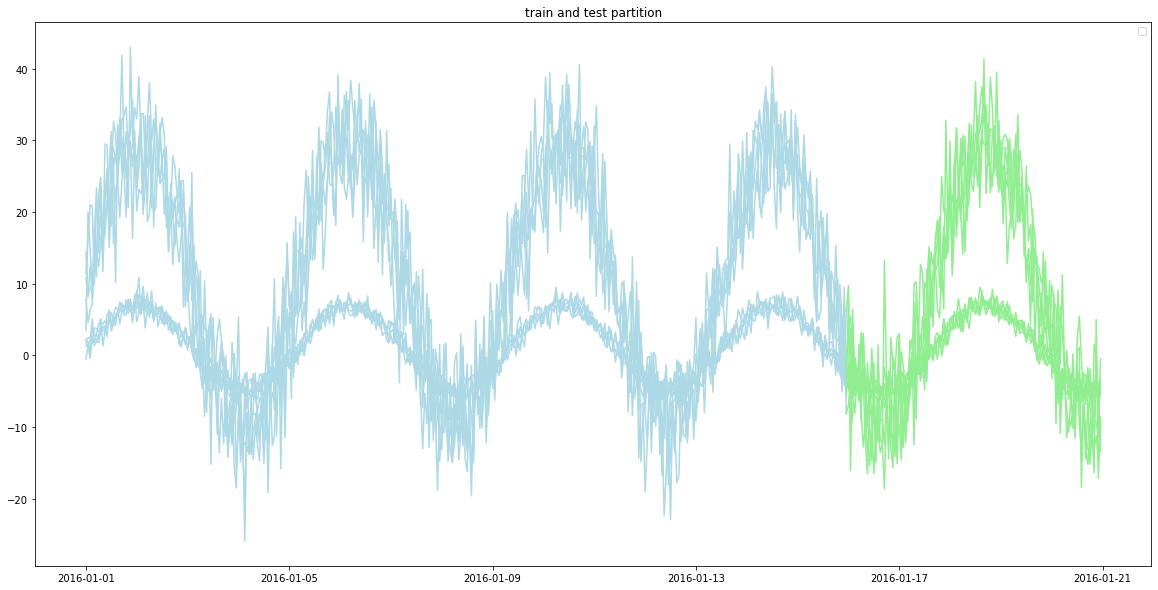

In [ ]:
plt.plot(train_ts.T, color='lightblue')
plt.plot(test_ts.T, color='lightgreen')
plt.title('train and test partition')
plt.legend()

**Pre-processing step**

In [ ]:
timesteps = 2
features = num_ts

In [ ]:
features

10

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

The split_sequence() function will split the univariate sequence into multiple samples where each sample has a specified number of time steps. As consequence, this function will also transform specific dates to time steps

In [ ]:
ts_X_test, ts_Y_test = split_sequence(test_ts.T.values, timesteps)
ts_X_train, ts_Y_train = split_sequence(train_ts.T.values, timesteps)

# reshape X as input for the lstm [samples, timesteps, features]
X_train = ts_X_train.reshape((ts_X_train.shape[0], ts_X_train.shape[1], features)) 
X_test = ts_X_test.reshape((ts_X_test.shape[0], ts_X_test.shape[1], features))

In [ ]:
# reshape X as input for the lstm [samples, timesteps, features]
X_train = ts_X_train.reshape((ts_X_train.shape[0], ts_X_train.shape[1], features)) 
X_test = ts_X_test.reshape((ts_X_test.shape[0], ts_X_test.shape[1], features)) 

We have split the dataset into 118 samples with 2 values (timesteps) each sample 

In [ ]:
X_test.shape, ts_Y_test.shape #  [samples, timesteps, features]

((119, 2, 10), (119, 10))

* We have a forecasting horizon of 1 (t+1) as we can see in the Y test set
* We need a sample input of two hours to forecast the next hour  

In [ ]:
X_test[0:5], ts_Y_test[0:5]

(array([[[ -0.97190137,  -1.43857905,  -8.11675849,  -2.27619501,
           -2.80861735,  -1.05808135,  -5.51015571,  -3.26635562,
            6.26397236,  -1.25441286],
         [  3.79456111,  -2.72535398,  -7.00053198,  -3.15308839,
           -4.9612746 ,  -1.36340666,   7.94522022,  -3.23456287,
            9.70996305,  -2.81571386]],
 
        [[  3.79456111,  -2.72535398,  -7.00053198,  -3.15308839,
           -4.9612746 ,  -1.36340666,   7.94522022,  -3.23456287,
            9.70996305,  -2.81571386],
         [  5.4090113 ,  -1.85362418,  -3.58920182,  -4.31190327,
            3.80747666,  -2.58504237, -16.06257744,  -1.88226208,
          -10.71291375,  -1.27644542]],
 
        [[  5.4090113 ,  -1.85362418,  -3.58920182,  -4.31190327,
            3.80747666,  -2.58504237, -16.06257744,  -1.88226208,
          -10.71291375,  -1.27644542],
         [  1.08661151,  -4.62848879,   6.43659082,  -0.32849985,
           -5.21336651,  -2.26306448,   3.92486424,  -2.21979011,
       

<sup>1</sup> *The deep quantile learning technique has been successfully applied in regression with a simple ANN model -  [see previous work](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/bayesian_deep_learning/uncertainty_estimation/quantile_regression/experiments/01-quantile_regression/01-quantile_regression_techniques.ipynb). As this technique is agnostic of the underlying deep learning model, here it is proposed an LSTM model instead in order to solve the forecasting problem.*

##### Mixture Density Networks

In [ ]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow_probability import distributions as tfd
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
#from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau


In [ ]:
class MDN(tf.keras.Model):

    def __init__(self, neurons=1000, components = 2, timesteps=2, features=100):
        super(MDN, self).__init__(name="MDN")
        self.neurons = neurons
        self.components = components
        
        self.h1 = LSTM(neurons, activation='relu', input_shape=(timesteps, features))
        self.h2 = Dense(neurons, activation="relu", name="h2")
        
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, name="mus")
        self.sigmas = Dense(components, activation="nnelu", name="sigmas")
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x = self.h1(inputs)
        x = self.h2(x)
        
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v, mu_v, sigma_v])

In [ ]:
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))


tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

In [ ]:
def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of parameter vectors.
    """
    return [parameter_vector[:,i*components:(i+1)*components] for i in range(no_parameters)]

In [ ]:
def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha, mu, sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    
    log_likelihood = gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y
    
    return -tf.reduce_mean(log_likelihood, axis=-1)

In [ ]:
no_parameters = 3

components = 2
neurons = 200

opt = tf.optimizers.Adam(1e-3)

In [ ]:
mdn = MDN(neurons=neurons, components=components, timesteps=timesteps, features=features)
mdn.compile(loss=gnll_loss, optimizer=opt)

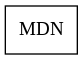

In [ ]:
keras.utils.plot_model(mdn, "model_lstm_mdn.png", show_shapes=True)

In [ ]:
X_train.shape, X_test.shape

((358, 2, 10), (119, 2, 10))

In [ ]:
ts_Y_train.shape, ts_Y_test.shape

((358, 10), (119, 10))

In [ ]:
%%time
#mdn.fit(x=x_train, y=y_train, epochs=1000, validation_data=(x_val, y_val), callbacks=[tensorboard], batch_size=128, verbose=0)
mdn.fit(x=X_train, y= ts_Y_train, epochs=100, validation_data=(X_test, ts_Y_test), batch_size=timesteps, verbose=1)

Epoch 1/100
179/179 [==============================] - 3s 8ms/step - loss: 3.5976 - val_loss: 3.1879
Epoch 2/100
179/179 [==============================] - 1s 6ms/step - loss: 3.1605 - val_loss: 2.9868
Epoch 3/100
179/179 [==============================] - 1s 5ms/step - loss: 2.9668 - val_loss: 2.9123
Epoch 4/100
179/179 [==============================] - 1s 5ms/step - loss: 2.9462 - val_loss: 2.8502
Epoch 5/100
179/179 [==============================] - 1s 5ms/step - loss: 2.8790 - val_loss: 2.9005
Epoch 6/100
179/179 [==============================] - 1s 5ms/step - loss: 2.8649 - val_loss: 2.8465
Epoch 7/100
179/179 [==============================] - 1s 5ms/step - loss: 2.8398 - val_loss: 2.8684
Epoch 8/100
179/179 [==============================] - 1s 6ms/step - loss: 2.8373 - val_loss: 2.8491
Epoch 9/100
179/179 [==============================] - 1s 5ms/step - loss: 2.8242 - val_loss: 2.8578
Epoch 10/100
179/179 [==============================] - 1s 5ms/step - loss: 2.8383 - val_lo

In [ ]:
X_test.shape

(119, 2, 10)

In [ ]:
y_pred = mdn.predict(X_test, verbose=0)
alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)

In [ ]:
len(mu_pred[:,0])

119

In [ ]:
ts_Y_train.shape

(358, 10)

In [ ]:
sigma_pred[:,0]

array([12.743086 ,  1.4928509,  7.9591193,  0.978022 ,  2.8604589,
        3.3616955,  3.7408125,  3.005779 ,  3.1291564,  5.1575084,
        3.4461803,  3.3697276,  2.268416 ,  2.7573977,  3.1068792,
        3.064297 ,  3.6829033,  7.6460896,  1.7843623,  5.1575503,
        4.6656313,  4.1103244,  2.6683922,  3.8459735,  3.8219304,
        9.213846 ,  2.6556268,  2.7331   ,  4.667392 ,  4.436075 ,
        2.3279247,  4.6526566,  1.889291 ,  2.8656778,  3.5747771,
        2.9907832,  3.8006575,  6.990503 ,  4.6760283,  2.6423647,
        2.426094 ,  3.0103612,  3.7877696,  4.613229 ,  2.2798438,
        4.1158237,  3.6696897,  5.9421806,  4.3865705,  3.6051974,
        5.7070208,  5.002588 ,  4.8070197,  4.7786026,  4.689947 ,
        4.900347 ,  3.982601 ,  4.3557262,  4.14209  ,  4.6257963,
        4.8287587,  4.889326 ,  4.595173 ,  4.580618 ,  4.643751 ,
        5.178256 ,  4.1827726,  4.500822 ,  4.762179 ,  4.910388 ,
        5.9838505,  5.139527 ,  4.294986 ,  3.6649988,  5.0724

Text(0.5, 51.0, 'time step')

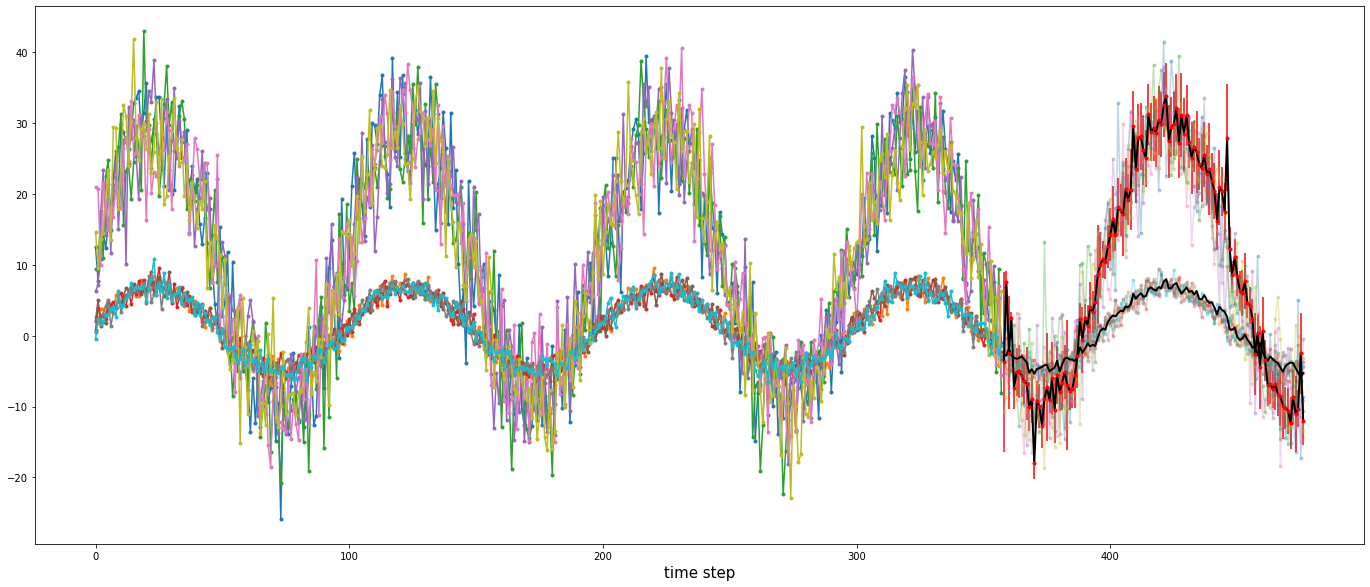

In [ ]:
  forecast_h = len(mu_pred[:,0])
  train_window = len(ts_Y_train)
  x_length = forecast_h+train_window
  aa=[x for x in range(x_length)]
  plt.figure(figsize=(20,8))
  plt.plot(aa[:train_window], ts_Y_train, marker='.', label="train")
  plt.plot(aa[train_window:], ts_Y_test, marker='.', label="test",  alpha=0.3)
  plt.plot(aa[train_window:], mu_pred[:,0].reshape(-1), label="forecast", color='black', linewidth=2)
  plt.errorbar(aa[train_window:], mu_pred[:,0], yerr=np.sqrt(sigma_pred[:,0])**2 , color='red', fmt='.'); 
  plt.plot(aa[train_window:], mu_pred[:,1].reshape(-1), label="forecast", color='black', linewidth=2)

  plt.tight_layout()
  plt.subplots_adjust(left=0.07)
  plt.xlabel('time step', size=15)
  #plt.legend(fontsize=15)

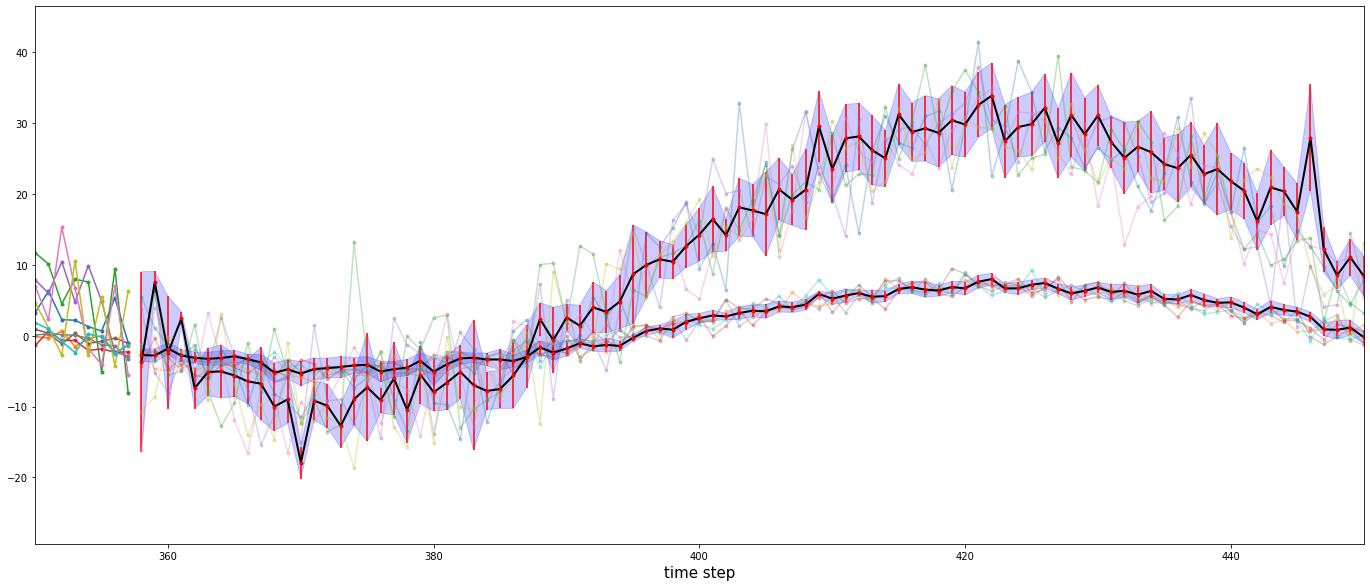

In [ ]:
forecast_h = len(mu_pred[:,0])
train_window = len(ts_Y_train)
x_length = forecast_h+train_window
aa=[x for x in range(x_length)]
plt.figure(figsize=(20,8))
plt.plot(aa[:train_window], ts_Y_train, marker='.', label="train")
plt.plot(aa[train_window:], ts_Y_test, marker='.', label="test",  alpha=0.3)
plt.plot(aa[train_window:], mu_pred[:,0].reshape(-1), label="forecast", color='black', linewidth=2)

mean_1, std_1 = mu_pred[:,0].reshape(-1), np.sqrt(sigma_pred[:,0])**2
plt.errorbar(aa[train_window:], mean_1, yerr=std_1 , color='red', fmt='.'); 
plt.fill_between(aa[train_window:], mean_1 - std_1, mean_1 + std_1, color='b', alpha=0.2)

mean_2, std_2 = mu_pred[:,1].reshape(-1), np.sqrt(sigma_pred[:,1])**2
plt.plot(aa[train_window:], mean_2, label="forecast", color='black', linewidth=2)
plt.errorbar(aa[train_window:], mean_2, yerr=std_2, color='red', fmt='.'); 
plt.fill_between(aa[train_window:], mean_2 - std_2, mean_2 + std_2, color='b', alpha=0.2)

plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.xlabel('time step', size=15)

plt.xlim(350,450)
plt.show()

In [ ]:
X_test[0].reshape(1,X_test[0].shape[0], -1)

array([[[-0.97190137, -1.43857905, -8.11675849, -2.27619501,
         -2.80861735, -1.05808135, -5.51015571, -3.26635562,
          6.26397236, -1.25441286],
        [ 3.79456111, -2.72535398, -7.00053198, -3.15308839,
         -4.9612746 , -1.36340666,  7.94522022, -3.23456287,
          9.70996305, -2.81571386]]])

In [ ]:
X_test.shape[0]

119

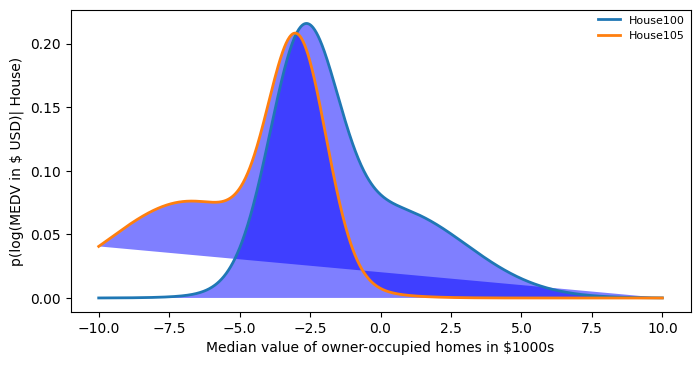

In [ ]:
sns.color_palette("tab10")

def plot_house_dist(ax, index, col_index):
    mdn_alpha, mdn_mu, mdn_sigma = slice_parameter_vectors(mdn.predict(X_test[index].reshape(1,X_test[index].shape[0], -1)))

    gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=mdn_alpha),
            components_distribution=tfd.Normal(
                loc=mdn_mu,       
                scale=mdn_sigma))
    pyx = gm.prob(x)
    la = "House{:3d}".format(index)
    ax.plot(x,pyx, alpha=1, color=sns.color_palette("tab10")[col_index], linewidth=2, label=la)
    ax.fill(x, pyx, facecolor='blue', alpha=0.5)
    
x = np.linspace(-10,10,int(1e3))

fig = plt.figure(figsize=(8,4), dpi=100)
ax = plt.gca()

houses_index = [100, 105]
icol = 0
for house_idx in houses_index:
    plot_house_dist(ax, house_idx, icol)
    icol+=1

ax.set_xlabel('Median value of owner-occupied homes in $1000s')
ax.set_ylabel("p(log(MEDV in $ USD)| House)")
ax.legend(loc=0, borderaxespad=0.1, framealpha=1.0, fancybox=True, ncol=1, shadow=True, frameon=False, fontsize=8)

plt.show()

In [ ]:
pal = sns.color_palette('cubehelix', n_colors=5)
print(pal.as_hex())

['#192d48', '#2b6f39', '#a1794a', '#d490c6', '#c3d9f3']


In [ ]:
X_test[0]

array([[-0.97190137, -1.43857905, -8.11675849, -2.27619501, -2.80861735,
        -1.05808135, -5.51015571, -3.26635562,  6.26397236, -1.25441286],
       [ 3.79456111, -2.72535398, -7.00053198, -3.15308839, -4.9612746 ,
        -1.36340666,  7.94522022, -3.23456287,  9.70996305, -2.81571386]])

In [ ]:
def house_dist(index, x):
    mdn_alpha, mdn_mu, mdn_sigma = slice_parameter_vectors(mdn.predict(X_test[index].reshape(1,X_test[index].shape[0], -1)))

    gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=mdn_alpha),
            components_distribution=tfd.Normal(
                loc=mdn_mu,       
                scale=mdn_sigma))
    pyx = gm.prob(x)
    return pyx
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


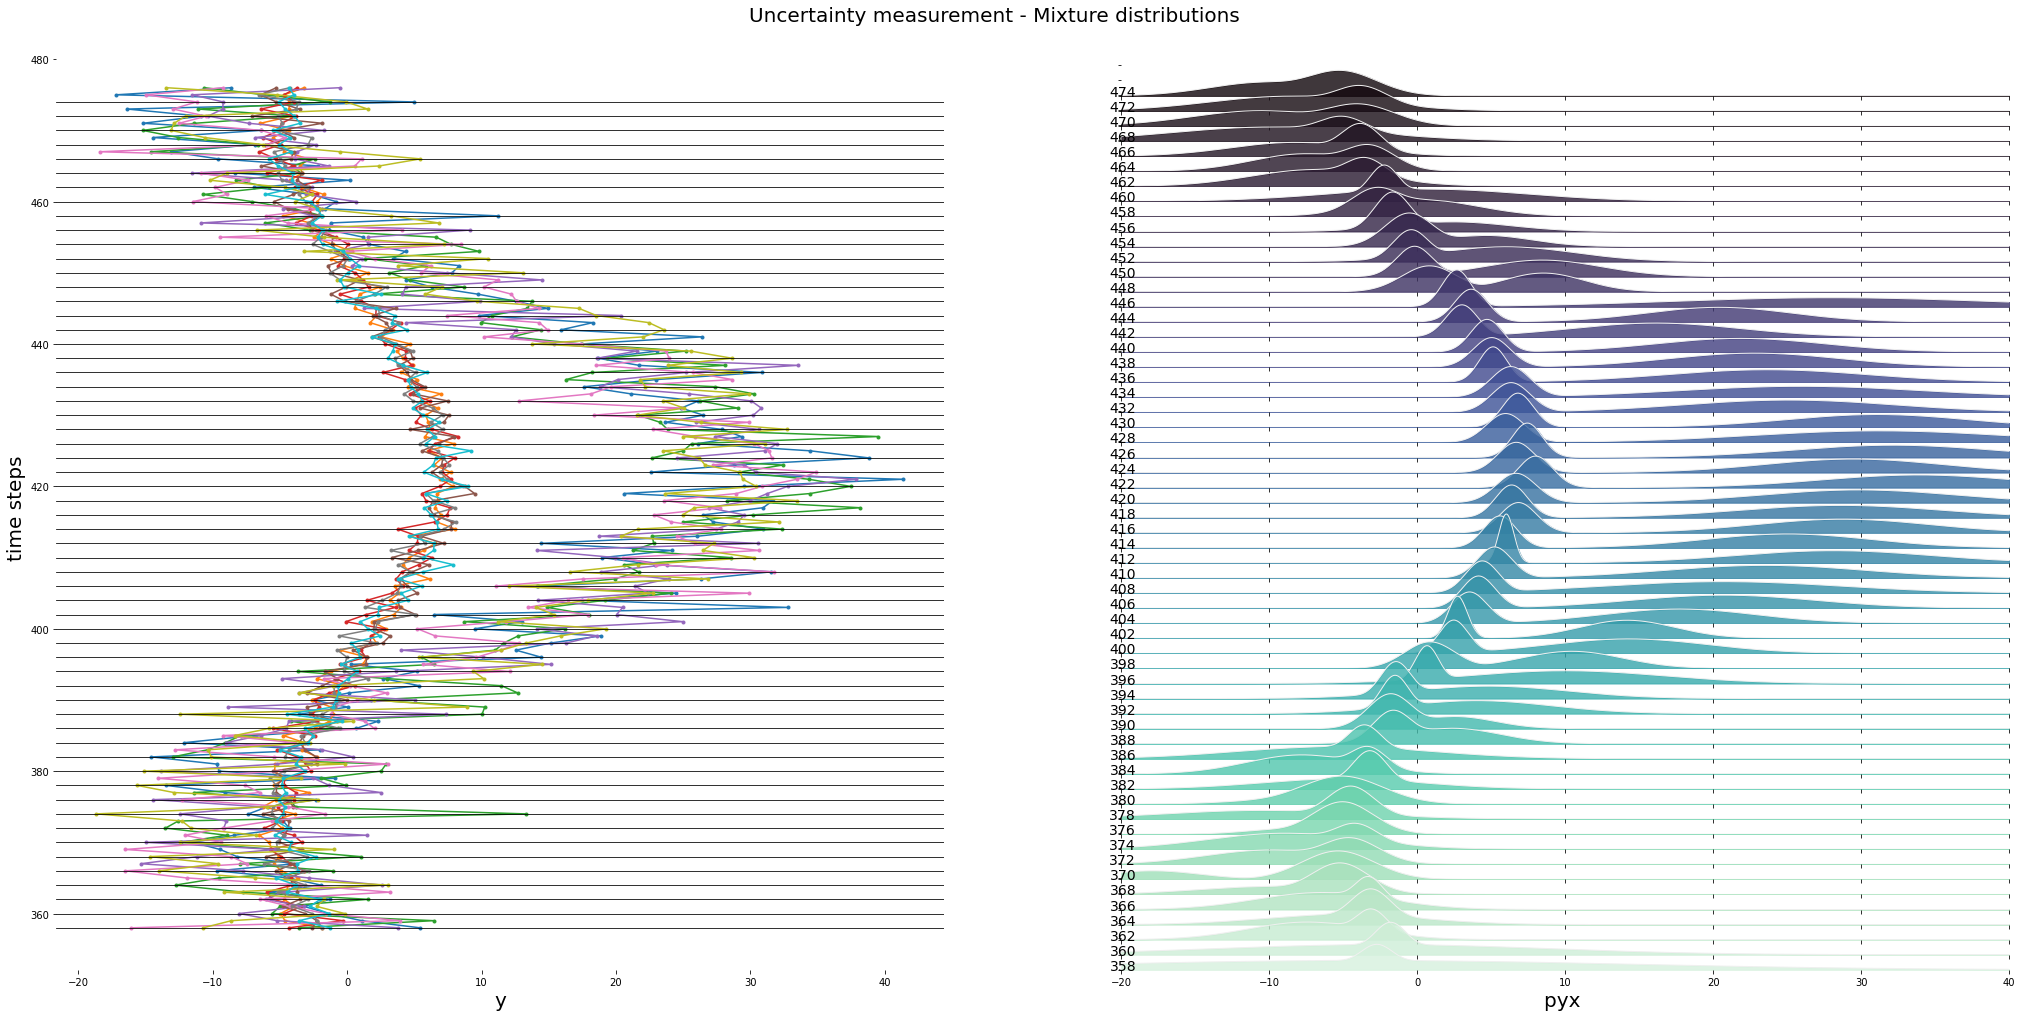

In [176]:
dates_index = list(range(0,119))[0:-1:2]
dates_index.sort(reverse=True)
pal = sns.color_palette('mako', n_colors=len(dates_index))
colors = pal.as_hex()

gs = grid_spec.GridSpec(len(dates_index),2)
fig = plt.figure(figsize=(35,17))


i = 0
ax_objs = []

#creating empty list
ax_objs = []
x = np.linspace(-20,40,int(1e3))



# ------- plot prediction intervals
forecast_h = len(mu_pred[:,0])
train_window = len(ts_Y_train)
x_length = forecast_h+train_window
aa=[x for x in range(x_length)]
ax_objs.append(fig.add_subplot(gs[0:, 0]))
ax_objs[-1].plot(ts_Y_test,aa[train_window:], marker='.', label="test")
# make background transparent
spines = ["top","right","left","bottom"]
for s in spines:
    ax_objs[-1].spines[s].set_visible(False)

ax_objs[-1].set_ylabel('time steps', fontsize=20)
ax_objs[-1].set_xlabel("y", fontsize=20)

for date_idx in dates_index:
    plt.axhline(y=aa[train_window:][date_idx], color='black', linestyle='-', linewidth=0.8)

gs.update(hspace=-0.7)

fig.text(0.40,0.9,"Uncertainty measurement - Mixture distributions",fontsize=20)


# ------- plot mixture distributions
for date_idx in dates_index:
    date_idx = dates_index[i]
    logprob = house_dist(date_idx, x)
   
    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 1]))

    # plotting the distribution
    ax_objs[-1].plot(x, np.sqrt(logprob),color="#f0f0f0",lw=1)
    ax_objs[-1].fill_between(x, np.sqrt(logprob) , alpha=0.8, color=colors[i])


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-20,40)
    ax_objs[-1].set_ylim(0,0.8)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == len(dates_index)-1:
        ax_objs[-1].set_xlabel("pyx ", fontsize=20)
        #ax_objs[-1].set_ylabel("time step", fontsize=20)
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    adj_date = str(aa[train_window:][date_idx])
    ax_objs[-1].text(-19,0, adj_date, fontsize=14, ha="right")

    i += 1


gs.update(hspace=-0.7)

plt.tight_layout()
plt.show()

